# Mērījumu rezultātu analīze

## Mērķis
Fiksēt mērījumu rezultātu izmaiņu no ikdienas sitācijas (fikšet anomālijas)

Kā dati tiek izmantoti VAS ES monitoringa programmatūras SKUDRA radiofrekvenču spektra skenēšanas mērījumu rezultāti.
### Sagaidāmais rezultāts
Sagaidāmo rezultātu var iedalīt divos posmos:
1. iegūt grafisku pārskatu par radiofrekvenču spektra aktivitātes izmaiņu laikā
2. izstrādāt mašīnmācīšanās algoritmu, kas identificē vai nākošais mērījums atbilst ikdienas situācijai, vai tiek konstatēta novirze (anomālija), iegūt novirzes koeficientu.

## Dati
Dati atrodas uz servera http://skudra/ kur mērījumu meta dati glabājas MySQL datu bāzē, un mērījumu rezultāti (mērījumu laika dati) strukturēti direktorija TXT failos
Dati ir:
- timestamp (ms)
- frekvence (MHz)
- fiksētā limeņa vērtība (dBuV/m)
 Mērījumu rezultāti tiek iegūti pēc mērījuma ID, lai izgūtu datus ir iespējami 2 risinājumi:
 - veidot SQL pieprasījumu, kur iegūst katras frekvences mērījuma ID (parametrs_id), un pēc tā veidot http pieprasījumu, kur rezultāts būs json datu struktūra, kas satur *timestamp* un līmeni, frekvence ir iegūstama no SQL pieprasījuma.
 - piekļūstot *file storge* (uz servera esošu direktorija ar http pieprasījuma *backdoor* ;) ) pēc mērījuma id, un nolasot visus failus
 

## Datu tīrīšana/apstrāde
Veicot datu apstrādi jāņem vērā:
- *timestamp* ir novērota iznāma problēma, ka daži no tiem satur 12 simbolus un daži 13, lai iegūtu korektu laiku no ms, tad *timestamp* ir jāsatur 13 simbolus.
- Lai noteiktu signāla aktivitāti, nepiciešams izmantot signāla līmeni, gadijumos, kad singāla līmenis ir "-", nozīmē, ka konkrētajā skenēkjuma mērījumā dotajā frekvencē singāls netika konstatēts, līdz ar to vērtības "-" būtu jāaistāj ar *NaN*.
- Lai salīdzinātu signālu izmaiņu laikā, un samazinātu datu apjomu (datu apjoms var sasniegt pat vairākus GB), tad izvērtēšanai nepieciešams izmant datus, kas apkopoti pa 5 min.
- Lai korekti attēlotu signālu aktivitāti ir jāsalīdzina signlā aizņemtība, jo salīdzinot kādā konkrētā laikā fiksēto signālu skaitu nebūtu korekti, jo var atšķirties monitoringa programmatūras "SKUDRA" skenēšana cikla ātrums, signāla aizņemtību iegūst: fiksēto singālu skaits/mērījumu ciklu skaits * 100% konkrētajā laika intervālā.

## Datu iegūšana ar SQL pieprasījumiem
papildus izvērtēsim katras datu iegūšanas metodes ātrdarbību

In [7]:
import time
start_time = time.time()

import mysql.connector
import pandas as pd
import numpy as np
import json
import requests


# mysql piekļuves dati
with open('mysql_config.json') as f:
    mysql_config = json.load(f)

db = mysql.connector.connect(
    host=mysql_config['host'],
    user=mysql_config['user'],
    passwd=mysql_config['passwd'],
    db=mysql_config['db']
)

#mērījumu ID
event_ref=  10015730;
parameters = pd.read_sql_query("SELECT id, freq, count, files FROM `ss_parameters` WHERE `event_ref` = "+ str(event_ref), db)
parameters.set_index('id')
param = parameters[['id','freq', 'count', 'files']]
skaits= len(param)
df = pd.DataFrame()

#http://skudra/api/parameters/timelevel/{id}
for index, row in param.iterrows():
    print(f"{index} no  {skaits}| frekvences mērījuma id: {row['id']}, frekvence: {row['freq']}")
    uri = "http://skudra/api/parameters/timelevel/" + str(row['id'])
    #print(uri)
    response = requests.get(uri)
    timedata = json.loads(response.text)
    timeDataP=pd.DataFrame(timedata, columns=['timestamp','level'])
    timeDataP['timestamp'] = timeDataP['timestamp'].map(lambda s: pd.to_datetime(s, unit='ms', errors='ignore'))
    timeDataP['level'] = timeDataP['level'].mask(timeDataP['level']==-30, np.nan)
    #timeDataP['level'] = timeDataP['level'].mask(timeDataP['level']==0.0, np.nan)
    #timeDataP.set_index('timestamp')
    #timeDataP.to_csv(str(param['id'][0]) + '_' + str(param['freq'][0])+'_level.csv')

    cycles = timeDataP.groupby(pd.Grouper(key='timestamp', freq='5min'))['timestamp'].count()
    counted = timeDataP.groupby(pd.Grouper(key='timestamp', freq='5min'))['level'].count()

    groupedData = pd.DataFrame({'timestamp': cycles.index, 'cycles': cycles, 'counted': counted, 'freq': row['freq']})
    groupedData.set_index('timestamp')
    #df.append(groupedData)
    #groupedData.to_csv(str(row['id']) + '_' + str(row['freq'])+'_5_min.csv')
    groupedData.to_csv('sql_event_'+str(event_ref) + '_5_min.csv', mode='a')
print(f"--- {(time.time() - start_time)} Datu iegūšanas laiks laiks ---")
#df.to_csv('event_'+str(event_ref) + '_5_min.csv', mode='a')

0 no  84| frekvences mērījuma id: 105754, frekvence: 162.5375
1 no  84| frekvences mērījuma id: 105755, frekvence: 153.1
2 no  84| frekvences mērījuma id: 105756, frekvence: 146.7875
3 no  84| frekvences mērījuma id: 105757, frekvence: 146.125
4 no  84| frekvences mērījuma id: 105758, frekvence: 170.5875
5 no  84| frekvences mērījuma id: 105759, frekvence: 176.2375
6 no  84| frekvences mērījuma id: 105760, frekvence: 151.7125
7 no  84| frekvences mērījuma id: 105761, frekvence: 176.8375
8 no  84| frekvences mērījuma id: 105762, frekvence: 178.7
9 no  84| frekvences mērījuma id: 105763, frekvence: 161.0875
10 no  84| frekvences mērījuma id: 105764, frekvence: 154.475
11 no  84| frekvences mērījuma id: 105765, frekvence: 149.125
12 no  84| frekvences mērījuma id: 105766, frekvence: 151.95
13 no  84| frekvences mērījuma id: 105767, frekvence: 168.6
14 no  84| frekvences mērījuma id: 105768, frekvence: 152.25
15 no  84| frekvences mērījuma id: 105769, frekvence: 150.025
16 no  84| frekvenc

Lai sekotu līdzi progresam, drukājam pašreiz apstrādājamā faila informāciju

## Datu iegūšana no *file storage*

Ņemot vērā ka no viena faila iegūsim ļoti lielu datu apjomu (apstrādāts fails var aizņemt pat 300 MB), tad jau pie apstrādes veiksim rezultātu sadalīšanu pa atseviškiem frekvenču diapazoniem, dalījums tiek viekts pēc šajās frekvencēs izmantojamām sakaru sistēmām atbilstoši [Nacionālajam frekvenču plānam](https://likumi.lv/doc.php?id=198903).

Lai kļūdu gadijumā notiktu ātrāka failu pastrāde, mērījumu rezultātus saglabājam atsevišķā direktorijā 'txt'

In [14]:
def readSkudrFiles(id):
    
    import time
    start_time = time.time()
    
    import requests
    import pandas as pd
    import numpy as np
    import os
    from bs4 import BeautifulSoup
    
    fbins=[(30, 87.5), (87.5, 108), (108, 145), (145, 180), (380, 430), (440, 470)]
    
    event_ref=  str(id);
    cwp = os.getcwd()
    os.chdir(cwp)
    path = os.path.join(os.getcwd(),  'event_'+str(event_ref))
    path_txt = os.path.join(path, 'txt')
    path_csv = os.path.join(path, 'csv')
    print(path_txt)
    
    if os.path.exists(path):
        print ("directory %s exist" % path)
    else:
        try:  
            os.mkdir(path)
        except OSError:  
            print (f"Direktorijas  {path} izveidošana neizdevās")
        else:  
            os.mkdir(path_txt)
            os.mkdir(path+'/csv')
            print (f"Direktorija vieksmīgi izveidot {path} ")
        
    
    
    url = 'http://runis/storage/skudra/'+ str(event_ref) +'/timelevel/'
    req = requests.get(url)
    soup = BeautifulSoup(req.text, 'lxml')
    
    anchorlist = soup.find_all('a')
    urlist = [el['href'] for el in anchorlist if el['href'].endswith('txt')]
    #print(url, urlist)
    for uri in urlist:
        filepath = os.path.join(path_txt, uri.replace('./', '').replace('%20', ' ').replace(':', '-'))
        
        print(filepath)
        if os.path.isfile(filepath) is False:
            response = requests.get(url + uri)
            #timedata = json.loads(response.tex
            f = open(filepath, mode="w")
            f.write(response.text)
            f.close()
            #uri = "http://skudra/api/parameters/timelevel/" + str(row['id'])

    print(f"--- {(time.time() - start_time)} Falu nolasīšanas laiks ---")
    
    flist = os.listdir(path_txt)
    #allData = pd.DataFrame()
    i=0
    for f in flist:
        i+=1
        df=pd.read_csv(path_txt+'/'+f, names=['timestamp', 'freq', 'level'])
        df['timestamp'] = df['timestamp'].map(lambda s: s if len(str(s)) == 13 else s/10)
        df['timestamp'] = df['timestamp'].map(lambda s: pd.to_datetime(s, unit='ms', errors='ignore'))
        df['level'] = df['level'].replace('-', np.nan)
        freq =df['freq'][0]
        print(i,freq, end=', ')

        
        cycles = df.groupby(pd.Grouper(key='timestamp', freq='5min'))['timestamp'].count()
        counted = df.groupby(pd.Grouper(key='timestamp', freq='5min'))['level'].count()

        groupedData = pd.DataFrame({'timestamp': cycles.index, 'cycles': cycles, 'counted': counted, 'freq': freq})
        #allData.append(groupedData)
        
        binname = ''
        for b  in fbins:
            if freq>=b[0] and freq<=b[1]:
                binname = str(b[0])+'_-_'+str(b[1])

        resultfile = path + '/event_'+str(event_ref)+'_range_'+binname+'_MHZ.csv'
        if os.path.isfile(resultfile) is False:
            groupedData.to_csv(resultfile, mode='a')
            #break
        else:
            groupedData.to_csv(resultfile, mode='a', header=False)
    print(f"--- {(time.time() - start_time)} Datu iegūšanas laiks laiks ---")
    return True

readSkudrFiles(10015730)

C:\Users\ilmarsl\develpment\python\event_10015730\txt
Direktorija vieksmīgi izveidot C:\Users\ilmarsl\develpment\python\event_10015730 
C:\Users\ilmarsl\develpment\python\event_10015730\txt\2019-02-07 16_11_46_21_162.5375.txt
C:\Users\ilmarsl\develpment\python\event_10015730\txt\2019-02-07 16_11_58_40_153.1.txt
C:\Users\ilmarsl\develpment\python\event_10015730\txt\2019-02-07 16_12_11_31_146.7875.txt
C:\Users\ilmarsl\develpment\python\event_10015730\txt\2019-02-07 16_12_23_3_146.125.txt
C:\Users\ilmarsl\develpment\python\event_10015730\txt\2019-02-07 16_12_36_54_170.5875.txt
C:\Users\ilmarsl\develpment\python\event_10015730\txt\2019-02-07 16_12_49_69_176.2375.txt
C:\Users\ilmarsl\develpment\python\event_10015730\txt\2019-02-07 16_13_01_50_151.7125.txt
C:\Users\ilmarsl\develpment\python\event_10015730\txt\2019-02-07 16_13_13_58_176.8375.txt
C:\Users\ilmarsl\develpment\python\event_10015730\txt\2019-02-07 16_13_26_96_178.7.txt
C:\Users\ilmarsl\develpment\python\event_10015730\txt\2019-02-

True

## Grafiksā attēlošana

Iegūstot sagrupētus datus, varam tos atēlot heatmap grafikā, kur x ass ir laiks, y datums un grafika vērtība (krāsa) ir aizņemtība

In [19]:
import os
flist = os.listdir(os.getcwd() + 'event_10015730/')

In [24]:
flist

['csv',
 'event_10015730_range_108_-_146_MHZ.csv',
 'event_10015730_range_146_-_173_MHZ.csv',
 'event_10015730_range__MHZ.csv',
 'txt']

In [27]:
flist1=[]
for f in flist:
    filename, file_extension = os.path.splitext(f)
    flist1.append({'name':f, 'ext': file_extension})

In [28]:
flist1

[{'name': 'csv', 'ext': ''},
 {'name': 'event_10015730_range_108_-_146_MHZ.csv', 'ext': '.csv'},
 {'name': 'event_10015730_range_146_-_173_MHZ.csv', 'ext': '.csv'},
 {'name': 'event_10015730_range__MHZ.csv', 'ext': '.csv'},
 {'name': 'txt', 'ext': ''}]

In [17]:
def createCharts(id):
    id= str(id)
    #10015968
    import pandas as pd
    import os
    import math
    import numpy as np

    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import seaborn as sns
    sns.set()
    
    path = f"{os.getcwd()}event_{id}/"

    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    filelist = os.listdir(path)
    for f_name in filelist:
        filename, file_extension = os.path.splitext(f_name)
        if file_extension == '.csv':
            df=pd.read_csv(path + f_name, na_values=['freq', 'timestamp'], low_memory=False)
            df = df.dropna()
            f1 = df['freq'].min()
            f2 = df['freq'].max()
            df['timestamp'] = df['timestamp'].map(lambda s: pd.to_datetime(s, format='%Y-%m-%d %H:%M:%S', errors='ignore'))
            #print(df.head())
            cycles = df.groupby(pd.Grouper(key='timestamp', freq='60min'))['cycles'].sum()
            counted = df.groupby(pd.Grouper(key='timestamp', freq='60min'))['counted'].sum()
            

            
            df = pd.DataFrame({'timestamp': cycles.index, 'cycles': cycles, 'counted': counted, 'occ': counted/cycles*100})
            df['just_date'] = df['timestamp'].dt.date
            df['just_time'] = df['timestamp'].dt.time
            
            
            
            
            table = pd.pivot_table(df, values='occ', index=['just_date'], columns=['just_time'], aggfunc=np.average)
            f, ax = plt.subplots(figsize=(25, 5))
            midpoint = (table.values[~np.isnan(table.values)].max() - table.values[~np.isnan(table.values)].min()) *0.8
            heat_plot = sns.heatmap(table, cmap='coolwarm', annot=True, linewidths=.5, fmt=".0f", ax=ax, center=midpoint, square=True)
            plt.text(0,0.9, str(f1) + " - " + str(f2) + " MHz", fontsize = 25, color='Black',)
            fig = heat_plot.get_figure()
            fig.savefig(path + filename + ".png")
            
    



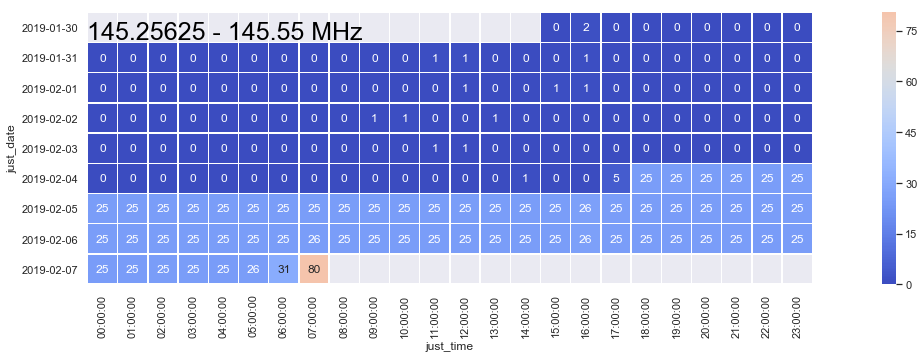

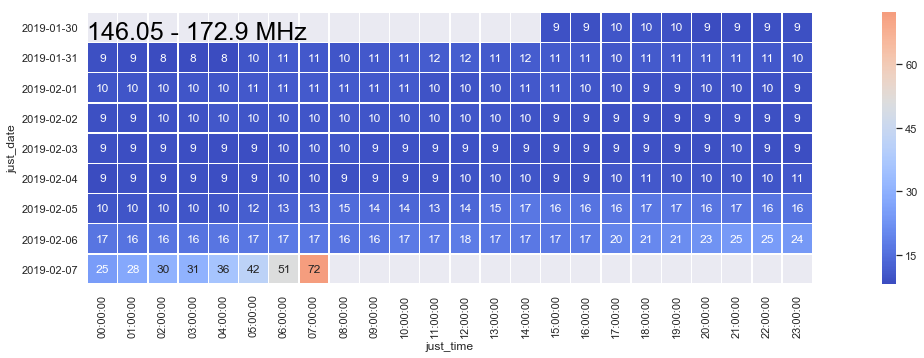

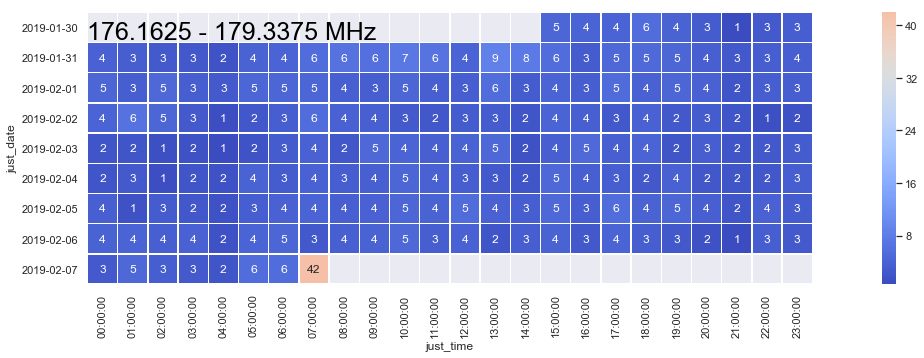

In [18]:
createCharts(10015730)

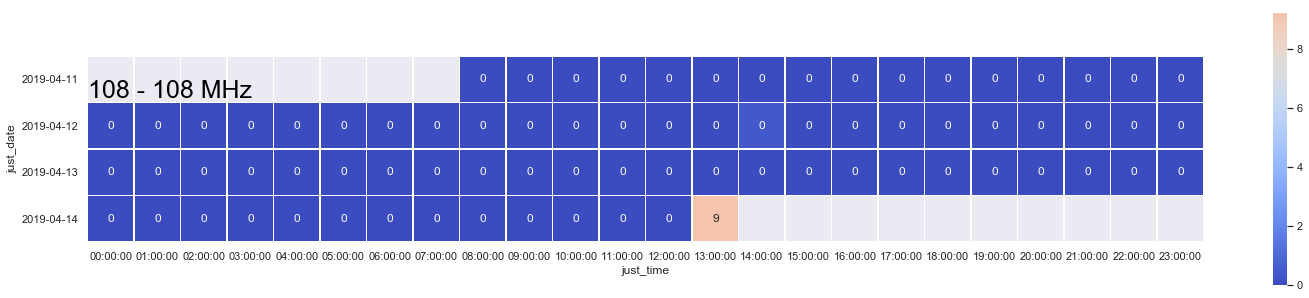

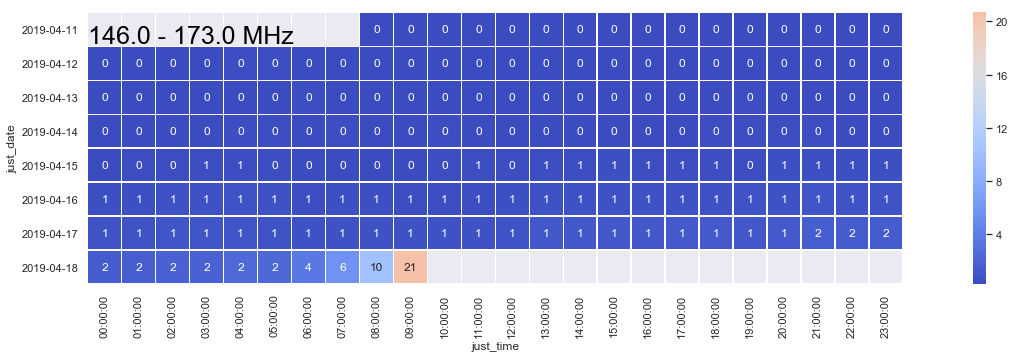

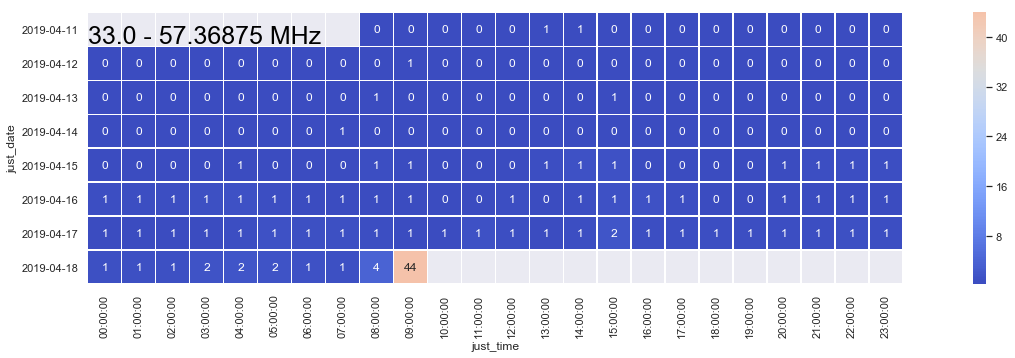

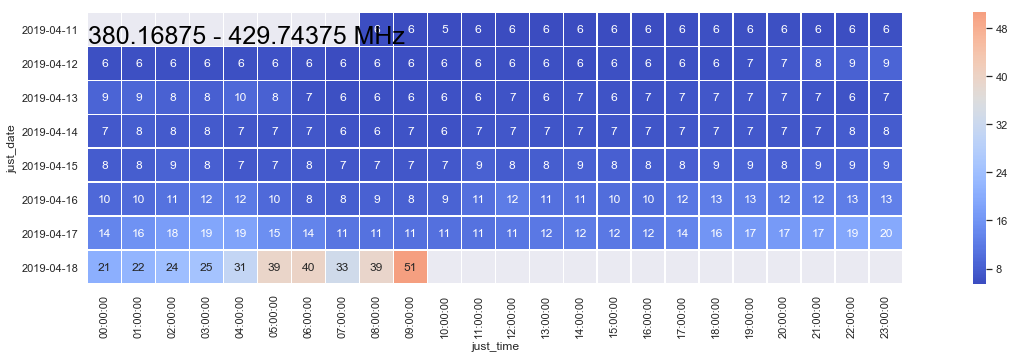

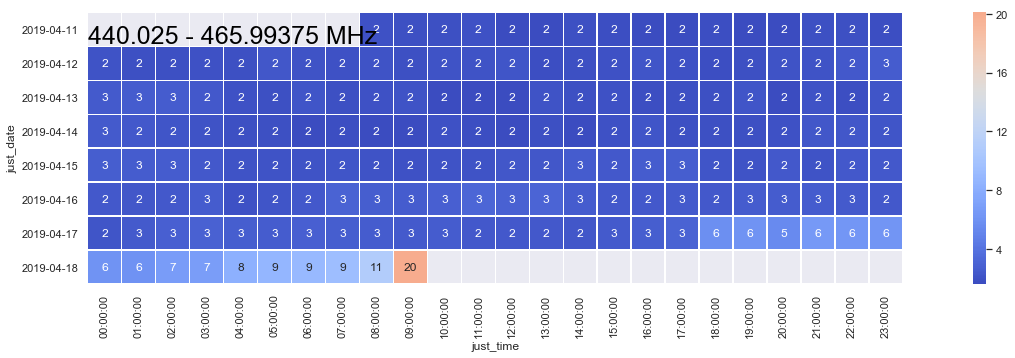

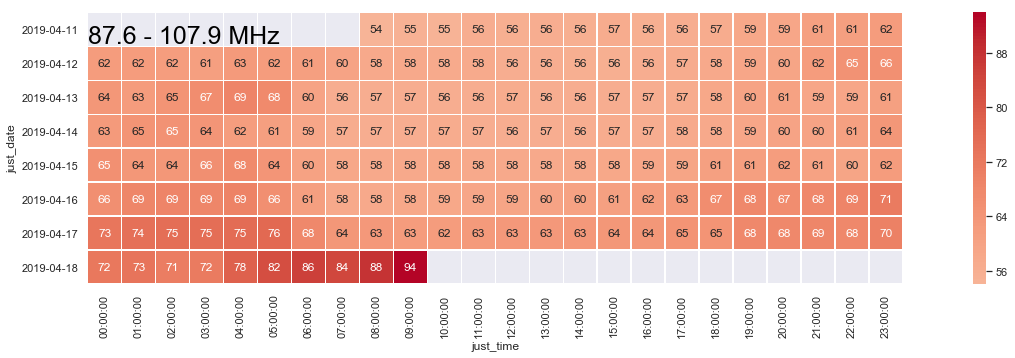

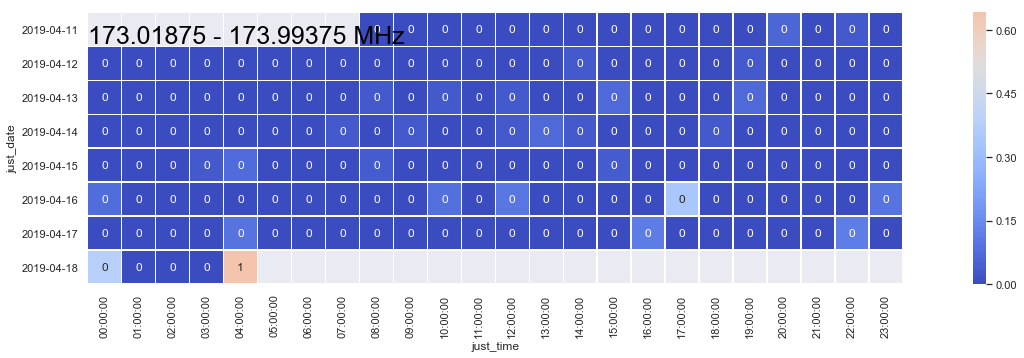

In [19]:
createCharts(10015968)